In [38]:
import numpy as np
from HARK.interpolation import LinearInterp
import matplotlib.pyplot as plt

def dcegmIntervals(x, v):
    """
    Find index vectors `rise` and `fall` such that `rise` holds the indeces `i`
    such that x[i+1]>x[i] and `fall` holds indeces `j` such that either
    - x[j+1] < x[j] or,
    - x[j]>x[j-1] and v[j]<v[j-1].

    The vectors are essential to the DCEGM algorithm, as they definite the
    relevant intervals to be used to construct the upper envelope of potential
    solutions to the (necessary) first order conditions.

    Parameters
    ----------
    x : np.ndarray
        array of points where `v` is evaluated
    v : np.ndarray
        array of values of some function of `x`

    Returns
    -------
    rise : np.ndarray
        see description above
    fall : np.ndarray
        see description above
    """
    # NOTE: assumes that the first segment is in fact increasing (forced in EGM
    # by augmentation with the constrained segment).
    # elements in common grid g

    # Identify index intervals of falling and rising regions
    # We need these to construct the upper envelope because we need to discard
    # solutions from the inverted Euler equations that do not represent optimal
    # choices (the FOCs are only necessary in these models).
    #
    # `fall` is a vector of indeces that represent the first elements in all
    # of the falling segments (the curve can potentially fold several times)
    fall = np.empty(0, dtype=int) # initialize with empty and then add the last point below while-loop

    rise = np.array([0]) # Initialize such thatthe lowest point is the first grid point
    i = 1 # Initialize
    while i <= len(x) - 2:
        # Check if the next (`ip1` stands for i plus 1) grid point is below the
        # current one, such that the line is folding back.
        ip1_falls = x[i+1] < x[i] # true if grid decreases on index increment
        i_rose = x[i] > x[i-1] # true if grid decreases on index decrement
        val_fell = v[i] < v[i-1] # true if value rises on index decrement

        if (ip1_falls and i_rose) or (val_fell and i_rose):

            # we are in a region where the endogenous grid is decreasing or
            # the value function rises by stepping back in the grid.
            fall = np.append(fall, i) # add the index to the vector

            # We now iterate from the current index onwards until we find point
            # where resources rises again. Unfortunately, we need to check
            # each points, as there can be multiple spells of falling endogenous
            # grids, so we cannot use bisection or some other fast algorithm.
            k = i
            while x[k+1] < x[k]:
                k = k + 1
            # k now holds either the next index the starts a new rising
            # region, or it holds the length of M, `m_len`.

            rise = np.append(rise, k)

            # Set the index to the point where resources again is rising
            i = k

        i = i + 1
    return rise, fall


# think! nanargmax makes everythign super ugly because numpy changed the wraning
# in all nan slices to a valueerror...it's nans, aaarghgghg
def calcMultilineEnvelope(M, C, V_T, commonM):
    """
    Do the envelope step of the DCEGM algorithm. Takes in market ressources,
    consumption levels, and inverse values from the EGM step. These represent
    (m, c) pairs that solve the necessary first order conditions. This function
    calculates the optimal (m, c, v_t) pairs on the commonM grid.

    Parameters
    ----------
    M : np.array
        market ressources from EGM step
    C : np.array
        consumption from EGM step
    V_T : np.array
        transformed values at the EGM grid
    commonM : np.array
        common grid to do upper envelope calculations on

    Returns
    -------


    """
    m_len = len(commonM)
    rise, fall = dcegmIntervals(M, V_T)

    # Add the last point to the vector for convenience below
    fall = np.append(fall, len(M)-1)
    num_kinks = len(fall) # number of kinks / falling EGM grids

    # Use these segments to sequentially find upper envelopes. commonVARNAME
    # means the VARNAME evaluated on the common grid with a cloumn for each kink
    # discovered in dcegmIntervals. This means that commonVARNAME is a matrix
    # common grid length-by-number of segments to consider. In the end, we'll
    # use nanargmax over the columns to pick out the best (transformed) values.
    # This is why we fill the arrays with np.nan's.
    commonV_T = np.empty((m_len, num_kinks))
    commonV_T[:] = np.nan
    commonC = np.empty((m_len, num_kinks))
    commonC[:] = np.nan

    # Now, loop over all segments as defined by the "kinks" or the combination
    # of "rise" and "fall" indeces. These (rise[j], fall[j]) pairs define regions
    for j in range(num_kinks):
        # Find points in the common grid that are in the range of the points in
        # the interval defined by (rise[j], fall[j]).
        below = M[rise[j]] >= commonM # boolean array of bad indeces below
        above = M[fall[j]] <= commonM # boolen array of bad indeces above
        in_range = below + above == 0 # pick out elements that are neither

        # create range of indeces in the input arrays
        idxs = range(rise[j], fall[j]+1)
        # grab ressource values at the relevant indeces
        m_idx_j = M[idxs]

        # based in in_range, find the relevant ressource values to interpolate
        m_eval = commonM[in_range]

        # re-interpolate to common grid
        commonV_T[in_range,j] = LinearInterp(m_idx_j, V_T[idxs], lower_extrap=True)(m_eval)
        commonC[in_range,j]  = LinearInterp(m_idx_j, C[idxs], lower_extrap=True)(m_eval) # Interpolat econsumption also. May not be nesserary
    # for each row in the commonV_T matrix, see if all entries are np.nan. This
    # would mean that we have no valid value here, so we want to use this boolean
    # vector to filter out irrelevant entries of commonV_T.
    row_all_nan = np.array([np.all(np.isnan(row)) for row in commonV_T])
    # Now take the max of all these line segments.
    idx_max = np.zeros(commonM.size, dtype = int)
    idx_max[row_all_nan == False] = np.nanargmax(commonV_T[row_all_nan == False], axis=1)

    # prefix with upper for variable that are "upper enveloped"
    upperV_T = np.zeros(m_len)

    # Set the non-nan rows to the maximum over columns
    upperV_T[row_all_nan == False] = np.nanmax(commonV_T[row_all_nan == False, :], axis=1)
    # Set the rest to nan
    upperV_T[row_all_nan] = np.nan

    # Add the zero point in the bottom
    if np.isnan(upperV_T[0]):
        # in transformed space space, utility of zero-consumption (-inf) is 0.0
        upperV_T[0] = 0.0
        # commonM[0] is typically 0, so this is safe, but maybe it should be 0.0
        commonC[0]  = commonM[0]

    # Extrapolate if NaNs are introduced due to the common grid
    # going outside all the sub-line segments
    IsNaN = np.isnan(upperV_T)
    upperV_T[IsNaN] = LinearInterp(commonM[IsNaN == False], upperV_T[IsNaN == False])(commonM[IsNaN])


    LastBeforeNaN = np.append(np.diff(IsNaN)>0, 0)
    LastId = LastBeforeNaN*idx_max # Find last id-number
    idx_max[IsNaN] = LastId[IsNaN]
    # Linear index used to get optimal consumption based on "id"  from max
    ncols = commonC.shape[1]
    rowidx = np.cumsum(ncols*np.ones(len(commonM), dtype=int))-ncols
    idx_linear = np.unravel_index(rowidx+idx_max, commonC.shape)
    upperC = commonC[idx_linear]
    upperC[IsNaN] = LinearInterp(commonM[IsNaN==0], upperC[IsNaN==0])(commonM[IsNaN])

    # TODO calculate cross points of line segments to get the true vertical drops
        
    upperM = commonM.copy() # anticipate this TODO
    
    return upperM, upperC, upperV_T


In [83]:
commonM = np.linspace(0,1.0,30)
m_in =np.array([0.0, 0.04, 0.2, 0.15, 0.1, 0.3, 0.6,0.5, 0.4, 0.6, 0.75,0.85])
c_in =np.array([0.0, 0.03, 0.1, 0.07, 0.05, 0.36, 0.4, 0.6, 0.8, 0.9,0.9,0.9])
v_t_in =np.array( [0.0, 0.05, 0.1,0.06, 0.04,0.2, 0.7, 0.5, 0.34, 0.9, 1.0, 1.2])

If we plot the relationship between the EGM grid, `m_in`, and the associated, transformed values, `v_t_in`, we see that it is not an increasing function. The transformed value function is not even a function, but a correspondance, if we connect the points successively.

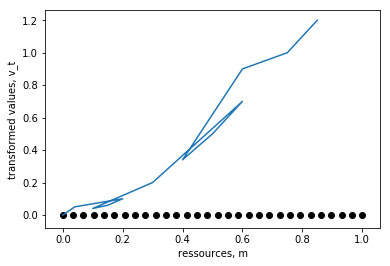

In [96]:
plt.plot(m_in,v_t_in)
plt.xlabel("ressources, m")
plt.ylabel("transformed values, v_t")
plt.scatter(commonM, commonM*0, c='k')

All points on this "curve" cannot be optimal. Since the first order conditions are only necessary in this class of models, we see that EGM will deliver `(m, c, v_t)` pairs that are sub-optimal. The DCEGM algorithm essentially considers the curve above, and does two things. First, it locates all increasing regions, and then it takes these segments and labels them from `0` up to the number of increasing segments (and as a result, kinks in the value function). Second, it loops through them in sequential order, and does an upper envelope step by re-interpolating onto the common grid shown as black dots in the figure.

`calcMultilineEnvelope` does these steps. It takes in the EGM ressource grid, `m_in`, consumption, `c_in`, transformed values (or original values, as the transformation function is monotonically increasing), `v_t_in`, as well as the grid to interpolate onto and calculate the envelope on.

In [93]:
m_out, c_out, v_out = calcMultilineEnvelope(m_in, c_in, v_t_in, commonM)

Plotting the output, we see that we have indeed constructed the upper envelope. The DCEGM algorithm allows for a relatively dense common grid, so it is possible to get a quite accurate approximation to the values associated with optimal choices, given the EGM step delivered sufficiently precise segments.

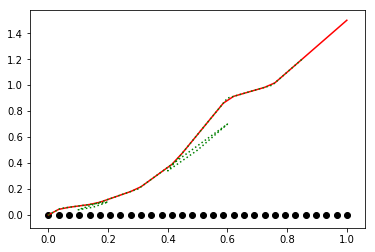

In [97]:
plt.plot(m_out, v_out, 'r')
plt.plot(mm, vt, 'g:')
plt.scatter(commonM, commonM*0, c='k')
plt.xlabel('ressources, m')
plt.ylabel('transformed values, v_t')

We can also look at the consumption function that emerges when we weed out the sub-optimal choices.

Text(0,0.5,'consumption, c')

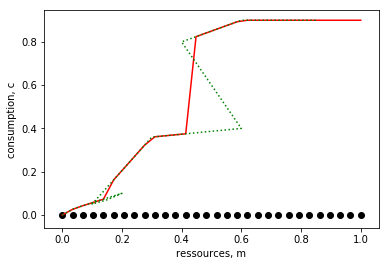

In [98]:
plt.plot(m_out, c_out, 'r')
plt.plot(m_in, cc,  'g:')
plt.scatter(commonM, commonM*0, c='k')
plt.xlabel('ressources, m')
plt.ylabel('consumption, c')

In [173]:
commonM = np.linspace(0,10.0,30)
m_in = np.array([1.0, 2.0, 3.0, 2.5, 2.0, 4.0, 5.0, 6.0])
c_in = np.array([1.0, 2.0, 3.0, 2.5, 2.0, 4.0, 5.0, 6.0])
v_in = np.array([0.5, 1.0, 1.5, 0.75, 0.5, 3.5, 5.0, 7.0])

In [177]:
slope_1 = (1.5 - 1.0)/(3.0 - 2.0)
slope_2 = (3.5 - 0.5)/(4.0 - 2.0)
m_cross = 2.0 + (0.5 - 1.0)/(slope_1 - slope_2)

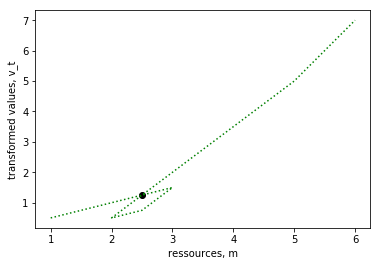

In [178]:
m_out, c_out, v_out = calcMultilineEnvelope(m_in, c_in, v_in, commonM)
plt.plot(m_in, v_in, 'g:')
#plt.plot(m_out, v_out)
plt.xlabel('ressources, m')
plt.ylabel('transformed values, v_t')
plt.scatter(m_cross, 1.0+(m_cross-2.0)*slope_1, c='k')

In [188]:
np.append(m_out, 3).sort()

In [179]:
np.argwhere()

2.5

In [180]:
m=m_cross

In [181]:
1.0 + (2.0+m)*slope_1

3.25

In [182]:
0.8 + (2.0+m)*slope_2

7.55

In [183]:
 m_cross*slope_2

3.75

In [212]:
slope_1 = (1.5 - 1.0)/(3.0 - 2.0)
slope_2 = (3.5 - 0.5)/(4.0 - 2.0)
m_cross = 2.0+(0.5 - 1.0)/(slope_1 - slope_2)

In [213]:
m_cross

2.5

In [224]:

m_out, c_out, v_out = calcMultilineEnvelope(m_in, c_in, v_in, commonM)

m_idx = 0

In [225]:
for m in m_out:
            if m > m_cross:
                break
                
            m_idx += 1

In [226]:
m_idx

8

In [231]:
m_out[m_idx]

2.7586206896551726

In [232]:
slope_2

1.5

In [243]:
# Just right of the cross, the second segment is optimal
true_v = 0.5 + (m_out[m_idx]-2.0)*slope_2

abs(v_out[m_idx] - true_v) < 1e-12

True

In [240]:
true_v

1.637931034482759

In [241]:
v_out[m_idx]

1.637931034482759

In [230]:
m_out

array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])